In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '5'
os.environ['VL_ROOT_DIR'] = '/root/vl-interp'

from methods.llava_utils import retrieve_logit_lens_llava, load_llava_state
from methods.blip_utils import retrieve_logit_lens_blip, load_blip_state

from methods.utils import load_image
from methods.algorithms import internal_confidence, internal_confidence_heatmap, internal_confidence_segmentation

from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

/root/miniconda3/envs/vl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "llava7b" # or "blip7b"

if model_name.startswith("llava"):
    model_state = load_llava_state()
    retrieve_logit_lens = retrieve_logit_lens_llava
elif model_name.startswith("blip"):
    model_state = load_blip_state()
    retrieve_logit_lens = retrieve_logit_lens_blip

/root/miniconda3/envs/vl/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]/root/miniconda3/envs/vl/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


In [3]:
img_path = os.path.join(os.environ["VL_ROOT_DIR"], "images/COCO_val2014_000000562150.jpg")

caption, softmax_probs = retrieve_logit_lens(model_state, img_path)

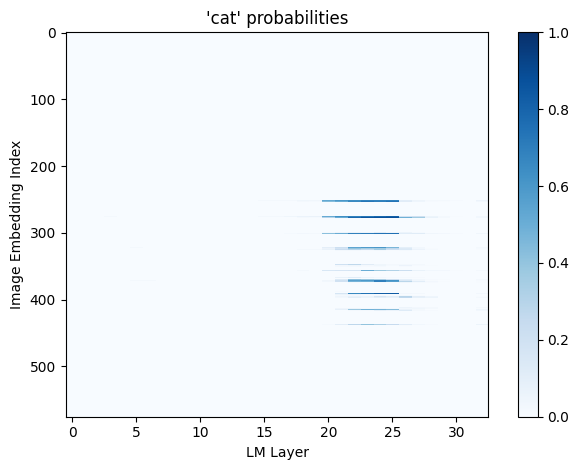

In [4]:
class_ = 'cat'
heatmap_data = internal_confidence_heatmap(model_state['tokenizer'], softmax_probs, class_)
num_image_embeddings = softmax_probs.shape[2]
im = plt.imshow(heatmap_data, aspect=30/num_image_embeddings, cmap='Blues', interpolation='nearest')
plt.title(f"'{class_}' probabilities")
plt.xlabel("LM Layer")
plt.ylabel("Image Embedding Index")
plt.tight_layout()
plt.clim(0, 1)
plt.colorbar()
plt.show()

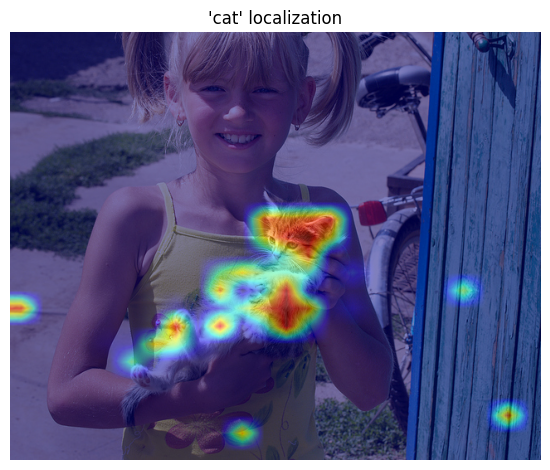

In [5]:
if model_name.startswith("llava"):
    img = load_image(img_path)
    img_width, img_height = img.size

    segmentation = internal_confidence_segmentation(model_state['tokenizer'], softmax_probs, class_, num_patches=24)
    segmentation_resized = (np.array(Image.fromarray(segmentation).resize((img_width, img_height), Image.BILINEAR)))

    plt.imshow(img)
    plt.imshow(segmentation_resized, cmap='jet', interpolation='bilinear', alpha=.5)
    plt.axis('off')
    plt.title(f"'{class_}' localization")
    plt.tight_layout()
    plt.show()
else:
    print(f"Cannot visualize localization for {model_name}")

In [6]:
print(f"Internal confidence: {internal_confidence(model_state['tokenizer'], softmax_probs, class_)}")

Internal confidence: 0.8783025741577148
